# Poisson's Equation
    Taylor Rubalcava

In [25]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from matplotlib import pyplot as plt, colors as mcolors
from imageio.v3 import imread
from scipy.sparse import diags
from scipy.sparse import identity
from scipy.sparse import lil_matrix
from scipy.sparse import block_diag

%matplotlib inline

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1])
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [26]:
def poisson_square(a, b, c, d, f, g, n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    # Creating the matrix A which is a (n-1) x (n-1) block tridiagonal matrix
    # with total size of (n-1)^2 x (n-1)^2
    # Defining the block matricies
    block_size = n-1

    # Creating the array of x values
    xs = np.linspace(a,b,n + 1)
    xs_truncated = xs[1:-1]
    ys = np.linspace(c,d,n + 1)
    h = xs[1]-xs[0]
    
    # Creating the A Matrix
    # Creating the T Matrix
    # Define the diagonals
    main_diagonal = -4 * np.ones(block_size)
    super_diagonal = np.ones(block_size - 1)
    sub_diagonal = np.ones(block_size - 1)

    # Creating the matrix
    T = diags(
        [main_diagonal, super_diagonal, sub_diagonal],  # List of diagonal values
        offsets=[0, 1, -1],                             # Offsets: 0 for main, 1 for super, -1 for sub
        format="csr"                                    # Compressed Sparse Row format
    )

    # Creating the A block diagonal matrix
    matricies = [T for i in range(n-1)]
    A = block_diag(matricies, format='csr', dtype=None)
    A.setdiag(1, k = n-1)
    A.setdiag(1, k = -(n-1))

    A = 1/(h**2) * A

    # Creating p
    p = []
    
    for i in range(1, n):
        p_temp = [0] * (n-1)
        p_temp[-1] = g(xs_truncated[-1], ys[i])
        p_temp[0] = g(xs_truncated[0], ys[i])
        # Adding the values of p_temp to p
        p = np.concatenate((p, p_temp))

    p = (1/(h**2)) * p

    # Creating q
    q = (1/(h**2)) * np.array([g(xs[i],ys[0]) for i in range(1,n)]) # Originally just the q1
    qn_1 = (1/(h**2)) * np.array([g(xs[i], ys[n]) for i in range(1,n)])

    for i in range(2, n-1):
        q_temp = np.array([0 for j in range(1,n)])
        # Adding it to the final array
        q = np.concatenate((q, q_temp))
    
    q = np.concatenate((q, qn_1))

    # Creating f
    f_array = []
    for i in range(1,n):
        f_temp = [f(xi,ys[i]) for xi in xs_truncated]
        f_array = np.concatenate((f_array, f_temp))

    # Using scipy.spares.linalg.spsolve to solve the linear system
    # AU + p + q = f
    U_innner = spla.spsolve(A, f_array - p - q)
    X, Y = np.meshgrid(xs,ys)
    g_values = g(X,Y)
    if isinstance(g_values, np.ndarray):
        U = g_values
    else:
        U = np.zeros((n+1,n+1))
    U[1:-1, 1:-1] = U_innner.reshape(n-1,n-1)
    return U
            

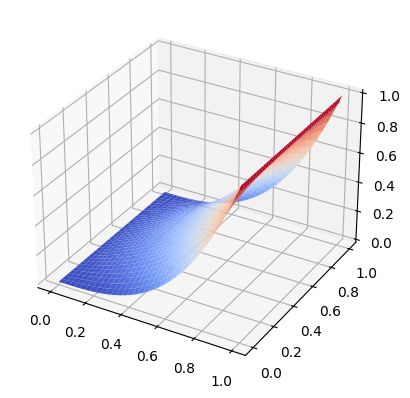

In [27]:
# Testing problem 1 by solving f = 0, g(x,y) = x**3
def test_problem1():
    a = 0
    b = 1
    c = 0
    d = 1
    f = lambda x, y: 0
    g = lambda x, y: x**3
    n = 100
    U = poisson_square(a, b, c, d, f, g, n)
    return U

U = test_problem1()

# Plotting the solution as a 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = U.shape[0]
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, U, cmap='coolwarm')
plt.show()

Solve 

\begin{align}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

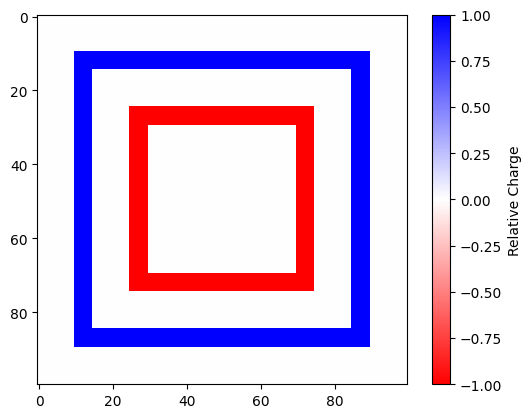

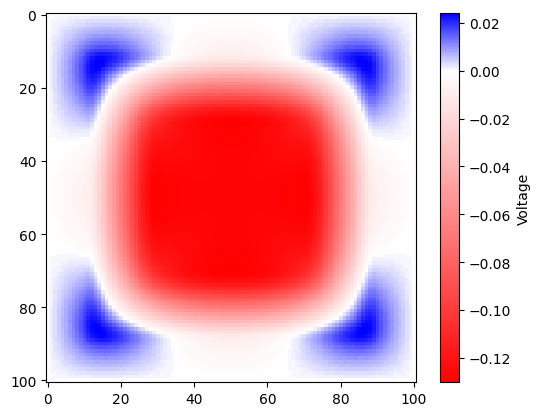

In [28]:
def source(X, Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)

    src[np.logical_or(np.logical_and(np.logical_or(abs(X - 1.5) < .1, abs(X + 1.5) < .1), abs(Y) < 1.6),
        np.logical_and(np.logical_or(abs(Y - 1.5) < .1, abs(Y + 1.5) < .1), abs(X) < 1.6))] = 1
    
    src[np.logical_or(np.logical_and(np.logical_or(abs(X - 0.9) < .1, abs(X + 0.9) < .1), abs(Y) <  1),
        np.logical_and(np.logical_or(abs(Y - 0.9) < .1, abs(Y + 0.9) < .1), abs(X) < 1))] = -1

    return src
    
# Generate a color dictionary for use with LinearSegmentedColormap
# that places red and blue at the min and max values of data
# and white when data is zero.
def genDict(data):
    zero = 1 / (1 - np.max(data) / np.min(data))
    cdict = {
        'red':   [(0, 1, 1), (zero, 1, 1), (1, 0, 0)],
        'green': [(0, 0, 0), (zero, 1, 1), (1, 0, 0)],
        'blue':  [(0, 0, 0), (zero, 1, 1), (1, 1, 1)]
    }
    return cdict

a1 = -2
b1 = 2
c1 = -2
d1 = 2
n = 100
X = np.linspace(a1, b1, n)
Y = np.linspace(c1, d1, n)
X, Y = np.meshgrid(X, Y)

plt.imshow(source(X, Y), cmap=mcolors.LinearSegmentedColormap('cmap', genDict(source(X, Y))))
plt.colorbar(label="Relative Charge")
plt.show()

# Solve the Poisson equation for the charge distribution
a = -2
b = 2
c = -2
d = 2
f = lambda x, y: -source(x, y)
g = lambda x, y: 0
n = 100
U = poisson_square(a, b, c, d, f, g, n)

# Plot the solution
plt.imshow(U, cmap=mcolors.LinearSegmentedColormap('cmap', genDict(U)))
plt.colorbar(label="Voltage")
plt.show()

Using the data file dr_jarvis.jpg as the source image $v$ and mount_rushmore.jpg as the destination image $u_0$, put Dr. Jarvis' face on Mount Rushmore. Use the finite difference Laplacian operator to calculate $f$ from $v$ .